In [1]:
import os
import functools
from itertools import groupby
import operator
from collections import defaultdict

import numpy as np
import pandas as pd

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

from paper_codon_hamiltonian import *

In [2]:
HPDF_amino = 'EGPALRRSYWRHLRRLVLGPPEPPFSHVCQVGDPVLRGVAAPVERAQLGGPELQRLTQRLVQVMRRRRCVGLSAPQLGVPRQVLALELPEALCRECPPRQRALRQMEPFPLRVFVNPSLRVLDSRLVTFPEGCESVAGFLACVPRFQAVQISGLDPNGEQVVWQASGWAARIIQHEMDHLQGCLFIDKMDSRTFTNVYWMKVND'

# Simulation following the Paper

## 1. From PLUS ONE,

In [10]:
weight_params = {'c_f': -0.1, 'c_GC': 1, 'c_R': 0.1, 'c_L': 0, 'epsilon_f': 0.001, 'rho_T': 0.5, 'epsilon': 1, 'infty': 5}
block_size = 10
verbose = 0

In [11]:
aminoacid_block = []
dwave_opt_codons = []
min_E_list = []

print("* Running", end=' ') if verbose == 0 else None
for ith in range(len(HPDF_amino) // block_size + 1):
    amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, ith)
    codon_fragment = Amino_acid_to_Codon(amino_fragment)

    if verbose >= 1:
        print('In amino acide seq, Run Block:',str(ith))
        print('=> Amino acids:', amino_fragment)
    if verbose >= 2:
        print('=> All possible codons:', codon_fragment())
    #====================

    #construct H_codon
    H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
    #run Dwave Sampler
    min_sample, min_E = H_codon.run_Dwave() #chain_strength=15
    opt_codon_frag = H_codon.outcome_codon_seq()

    #====================
    if verbose ==0:
        print(".", end=' ')
    elif verbose >= 2:
        print('=> Ground states:', min_sample)
    elif verbose >= 1:
        print('=> Optimal codons:', opt_codon_frag)



    aminoacid_block.append(amino_fragment)
    dwave_opt_codons.append(opt_codon_frag[0])
    min_E_list.append(min_E)


* Running . . . . . . . . . . . . . . . . . . . . . 

#### Outcomes

In [12]:
dwave_opt_codon_list = ["".join(dwave_opt_codons[x]) for x in range(len(dwave_opt_codons))]
rslt_df = pd.DataFrame(list(zip(aminoacid_block, dwave_opt_codon_list, min_E_list)),
                        columns=['amino acid', 'codon', "Energy"])
rslt_df

,amino acid,codon,Energy
0,EGPALRRSYW,GAAGGUCCAGCACUACGUCGAUCAUAUUGG,-10.460427
1,RHLRRLVLGP,AGACAUCUCAGACGACUCGUACUUGGACCG,-11.452121
2,PEPPFSHVCQ,CCAGAGCCACCAUUCUCACACGUAUGUCAG,-10.056810
3,VGDPVLRGVA,GUAGGAGAUCCUGUACUACGAGGAGUAGCA,-10.419756
4,APVERAQLGG,GCUCCAGUAGAGCGUGCACAGCUAGGAGGA,-10.755600
5,PELQRLTQRL,CCUGAGCUACAGAGACUGACACAGCGACUC,-11.742526
6,VQVMRRRRCV,GUACAGGUCAUGCGUAGACGACGAUGUGUA,-11.561045
7,GLSAPQLGVP,GGUCUCUCAGCUCCUCAGCUAGGAGUUCCU,-10.249528
8,RQVLALELPE,CGACAGGUACUCGCUCUCGAGCUACCUGAG,-11.233366
9,ALCRECPPRQ,GCUCUAUGUAGAGAGUGUCCACCUAGACAG,-11.151456


In [16]:
dwave_codon_RNA = "".join(rslt_df['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print("-"*30)
print(f"dwave_codon (block-size: {block_size})")
print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")

#GC
from Bio.SeqUtils import GC
GC_dwave = GC(dwave_codon_DNA)
print(f"GC of dwave_codon : {GC_dwave}")

------------------------------
dwave_codon (block-size: 10)
CAI of dwave_codon for human : 0.6077472412538883
CAI of dwave_codon for ecoli : 0.3794776527399371
GC of dwave_codon : 52.072968490878935


In [14]:
def getGCDistribution(sequence : str, window=30) -> list : 
    seq_chunks = [sequence[i:i+window] for i in range(len(sequence)-window)]
    assert len(seq_chunks) == len(sequence) - window
    GC_li = []
    for seqC in seq_chunks:
        GC_li.append(GC(seqC))
    
    return GC_li

GCd_ref = getGCDistribution(dwave_codon_DNA)

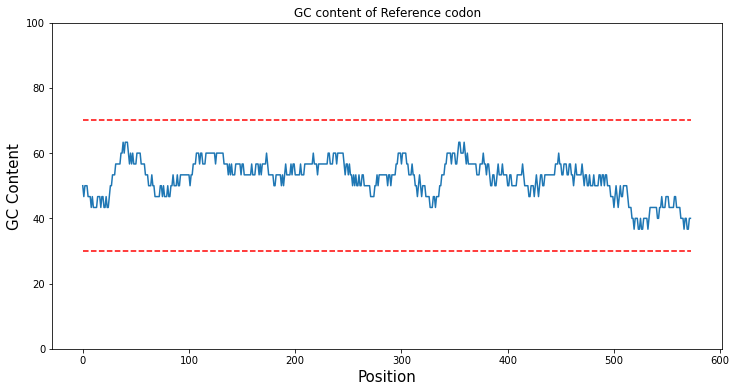

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

## 2. From arXiv,

In [3]:
weight_params = {'c_f': -0.1, 'c_GC': 1, 'c_R': 0.1, 'c_L': 0, 'epsilon_f': 0.001, 'rho_T': 0.5, 'epsilon': 1, 'infty': 10}
block_size = 5
verbose = 0

In [4]:
aminoacid_block = []
dwave_opt_codons = []
min_E_list = []

print("* Running", end=' ') if verbose == 0 else None
for ith in range(len(HPDF_amino) // block_size + 1):
    amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, ith)
    codon_fragment = Amino_acid_to_Codon(amino_fragment)

    if verbose >= 1:
        print('In amino acide seq, Run Block:',str(ith))
        print('=> Amino acids:', amino_fragment)
    if verbose >= 2:
        print('=> All possible codons:', codon_fragment())
    #====================

    #construct H_codon
    H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
    #run Dwave Sampler
    min_sample, min_E = H_codon.run_Dwave() #chain_strength=15
    opt_codon_frag = H_codon.outcome_codon_seq()

    #====================
    if verbose ==0:
        print(".", end=' ')
    elif verbose >= 2:
        print('=> Ground states:', min_sample)
    elif verbose >= 1:
        print('=> Optimal codons:', opt_codon_frag)



    aminoacid_block.append(amino_fragment)
    dwave_opt_codons.append(opt_codon_frag[0])
    min_E_list.append(min_E)


* Running . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

#### Outcomes

In [5]:
dwave_opt_codon_list = ["".join(dwave_opt_codons[x]) for x in range(len(dwave_opt_codons))]
rslt_df = pd.DataFrame(list(zip(aminoacid_block, dwave_opt_codon_list, min_E_list)),
                        columns=['amino acid', 'codon', "Energy"])
rslt_df

,amino acid,codon,Energy
0,EGPAL,GAAGGACCUGCUCUA,-5.281473
1,RRSYW,AGACGAUCGUACUGG,-5.808046
2,RHLRR,AGACAUCUACGACGA,-6.450995
3,LVLGP,CUAGUACUAGGACCA,-5.819852
4,PEPPF,CCUGAGCCUCCAUUC,-4.777873
5,SHVCQ,UCACACGUAUGUCAG,-5.855298
6,VGDPV,GUAGGAGAUCCUGUA,-4.864252
7,LRGVA,CUACGAGGAGUAGCU,-5.812834
8,APVER,GCUCCUGUAGAGAGA,-5.630532
9,AQLGG,GCUCAGCUAGGAGGA,-5.632123


In [7]:
dwave_codon_RNA = "".join(rslt_df['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print("-"*30)
print("dwave_codon (block-size:5)")
print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")

#GC
from Bio.SeqUtils import GC
GC_dwave = GC(dwave_codon_DNA)
print(f"GC of dwave_codon : {GC_dwave}")

------------------------------
dwave_codon (block-size:5)
CAI of dwave_codon for human : 0.5826788219520603
CAI of dwave_codon for ecoli : 0.3255487685395698
GC of dwave_codon : 48.92205638474295


In [8]:
def getGCDistribution(sequence : str, window=30) -> list : 
    seq_chunks = [sequence[i:i+window] for i in range(len(sequence)-window)]
    assert len(seq_chunks) == len(sequence) - window
    GC_li = []
    for seqC in seq_chunks:
        GC_li.append(GC(seqC))
    
    return GC_li

GCd_ref = getGCDistribution(dwave_codon_DNA)

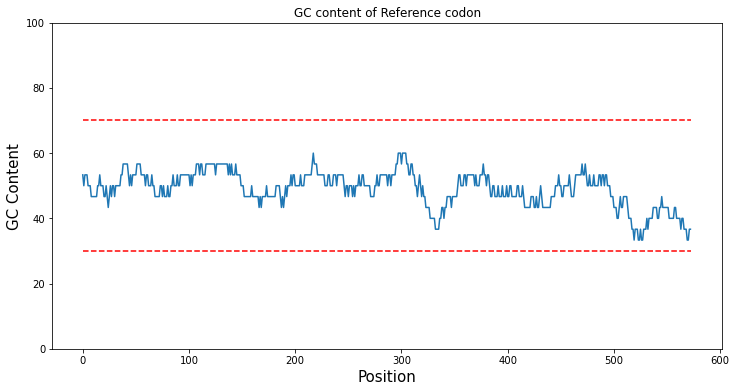

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

---
# Our works

## 0. 
Reference: <br>
block-size=5 \& default weight parameters

In [19]:
df_opt_codon = pd.read_csv('./jhlee/rslt/HPDF/HPDF_cS5_nT1_woL.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print("-"*30)
print("dwave_codon (block-size:5)")
print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")

#GC
from Bio.SeqUtils import GC
GC_dwave = GC(dwave_codon_DNA)
print(f"GC of dwave_codon : {GC_dwave}")

------------------------------
dwave_codon (block-size:5)
CAI of dwave_codon for human : 0.6577886323903238
CAI of dwave_codon for ecoli : 0.8123250512375765
GC of dwave_codon : 66.16915422885572


## 1. 
$c_f=0.1, \rho_T=0.5$, block_size=5

In [12]:
weight_params = {'c_f': 0.1, 'c_GC': 1, 'c_R': 0.1, 'c_L': 0, 'epsilon_f': 0.000, 'rho_T': 0.5, 'epsilon': 1, 'infty': 10}

In [5]:
block_size = 5
verbose = 0

aminoacid_block = []
dwave_opt_codons = []
min_E_list = []

print("* Running", end=' ') if verbose == 0 else None
for ith in range(len(HPDF_amino) // block_size + 1):
    amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, ith)
    codon_fragment = Amino_acid_to_Codon(amino_fragment)

    if verbose >= 1:
        print('In amino acide seq, Run Block:',str(ith))
        print('=> Amino acids:', amino_fragment)
    if verbose >= 2:
        print('=> All possible codons:', codon_fragment())
    #====================

    #construct H_codon
    H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
    #run Dwave Sampler
    min_sample, min_E = H_codon.run_Dwave() #chain_strength=15
    opt_codon_frag = H_codon.outcome_codon_seq()

    #====================
    if verbose ==0:
        print(".", end=' ')
    elif verbose >= 2:
        print('=> Ground states:', min_sample)
    elif verbose >= 1:
        print('=> Optimal codons:', opt_codon_frag)



    aminoacid_block.append(amino_fragment)
    dwave_opt_codons.append(opt_codon_frag[0])
    min_E_list.append(min_E)


* Running . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

#### Outcomes

In [ ]:
dwave_opt_codon_list = ["".join(dwave_opt_codons[x]) for x in range(len(dwave_opt_codons))]
rslt_df = pd.DataFrame(list(zip(aminoacid_block, dwave_opt_codon_list, min_E_list)),
                        columns=['amino acid', 'codon', "Energy"])
rslt_df

In [11]:
dwave_codon_RNA = "".join(rslt_df['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print("-"*30)
print("dwave_codon (block-size:5)")
print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")

#GC
from Bio.SeqUtils import GC
GC_dwave = GC(dwave_codon_DNA)
print(f"GC of dwave_codon : {GC_dwave}")

------------------------------
dwave_codon (block-size:5)
CAI of dwave_codon for human : 0.6645985930222221
CAI of dwave_codon for ecoli : 0.8213749883449528
GC of dwave_codon : 66.33499170812604


In [9]:
def getGCDistribution(sequence : str, window=30) -> list : 
    seq_chunks = [sequence[i:i+window] for i in range(len(sequence)-window)]
    assert len(seq_chunks) == len(sequence) - window
    GC_li = []
    for seqC in seq_chunks:
        GC_li.append(GC(seqC))
    
    return GC_li

GCd_ref = getGCDistribution(dwave_codon_DNA)

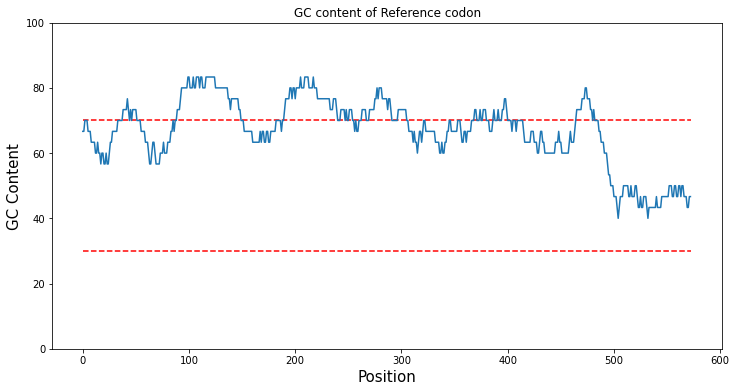

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

## 2.
$c_f=0.1, \rho_T =0.1$

In [13]:
weight_params = {'c_f': 0.1, 'c_GC': 1, 'c_R': 0.1, 'c_L': 0, 'epsilon_f': 0.000, 'rho_T': 0.1, 'epsilon': 1, 'infty': 10}
block_size = 5
verbose = 0

In [14]:
aminoacid_block = []
dwave_opt_codons = []
min_E_list = []

print("* Running", end=' ') if verbose == 0 else None
for ith in range(len(HPDF_amino) // block_size + 1):
    amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, ith)
    codon_fragment = Amino_acid_to_Codon(amino_fragment)

    if verbose >= 1:
        print('In amino acide seq, Run Block:',str(ith))
        print('=> Amino acids:', amino_fragment)
    if verbose >= 2:
        print('=> All possible codons:', codon_fragment())
    #====================

    #construct H_codon
    H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
    #run Dwave Sampler
    min_sample, min_E = H_codon.run_Dwave() #chain_strength=15
    opt_codon_frag = H_codon.outcome_codon_seq()

    #====================
    if verbose ==0:
        print(".", end=' ')
    elif verbose >= 2:
        print('=> Ground states:', min_sample)
    elif verbose >= 1:
        print('=> Optimal codons:', opt_codon_frag)



    aminoacid_block.append(amino_fragment)
    dwave_opt_codons.append(opt_codon_frag[0])
    min_E_list.append(min_E)


* Running . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

#### Outcomes

In [15]:
dwave_opt_codon_list = ["".join(dwave_opt_codons[x]) for x in range(len(dwave_opt_codons))]
rslt_df = pd.DataFrame(list(zip(aminoacid_block, dwave_opt_codon_list, min_E_list)),
                        columns=['amino acid', 'codon', "Energy"])
rslt_df

,amino acid,codon,Energy
0,EGPAL,GAAGGUCCGGCGCUG,-3.527545
1,RRSYW,CGUCGUAGCUAUUGG,-4.254040
2,RHLRR,CGUCAUCUGCGUCGU,-4.533606
3,LVLGP,CUCGUGCUCGGUCCG,-3.550286
4,PEPPF,CCGGAACCGCCGUUC,-3.152877
5,SHVCQ,UCUCAUGUGUGUCAG,-4.425568
6,VGDPV,GUUGGUGAUCCGGUU,-3.204371
7,LRGVA,CUGCGUGGUGUCGCG,-3.754065
8,APVER,GCGCCGGUAGAGCGU,-3.638258
9,AQLGG,GCGCAGCUCGGUGGU,-3.616236


In [16]:
dwave_codon_RNA = "".join(rslt_df['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print("-"*30)
print("dwave_codon (block-size:5)")
print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")

#GC
from Bio.SeqUtils import GC
GC_dwave = GC(dwave_codon_DNA)
print(f"GC of dwave_codon : {GC_dwave}")

------------------------------
dwave_codon (block-size:5)
CAI of dwave_codon for human : 0.6087375476981127
CAI of dwave_codon for ecoli : 0.789937262768329
GC of dwave_codon : 60.69651741293532


In [17]:
def getGCDistribution(sequence : str, window=30) -> list : 
    seq_chunks = [sequence[i:i+window] for i in range(len(sequence)-window)]
    assert len(seq_chunks) == len(sequence) - window
    GC_li = []
    for seqC in seq_chunks:
        GC_li.append(GC(seqC))
    
    return GC_li

GCd_ref = getGCDistribution(dwave_codon_DNA)

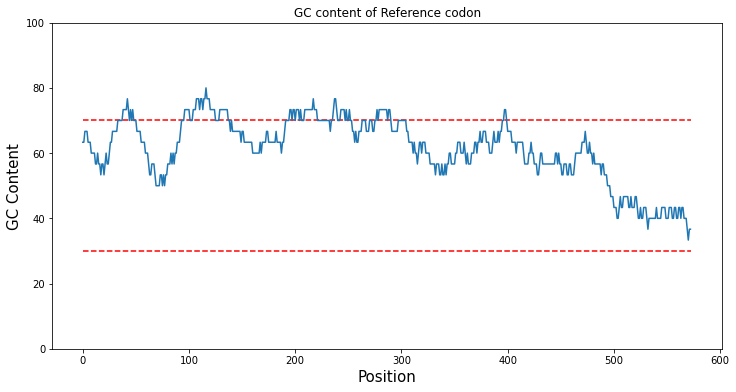

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()